In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 112
CHANNELS = 3

In [ ]:
csv_file_path = '/content/metrics_scores.csv'
ssim_scores = pd.read_csv(csv_file_path)

In [ ]:
ssim_scores = ssim_scores[['Image', 'SSIM_Score']]

In [ ]:
def load_dataset(base_path, ssim_scores):
    left_images = []
    right_images = []
    labels = []

    for distortion_type in os.listdir(base_path):
        distortion_path = os.path.join(base_path, distortion_type)
        if os.path.isdir(distortion_path):
            for file in os.listdir(distortion_path):
                if file.endswith('_l.bmp'):
                    left_file_path = os.path.join(distortion_path, file)
                    right_file_path = left_file_path.replace('_l.bmp', '_r.bmp')

                    img_base_name = file.split('_')[0]

                    if os.path.exists(right_file_path):
                        if img_base_name in ssim_scores['Image'].values:
                            left_img = load_img(left_file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
                            right_img = load_img(right_file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

                            left_img_array = img_to_array(left_img)
                            right_img_array = img_to_array(right_img)

                            left_images.append(left_img_array)
                            right_images.append(right_img_array)

                            label = ssim_scores[ssim_scores['Image'] == img_base_name]['SSIM_Score'].values[0]
                            labels.append(label)
                        else:
                            print(f"Warning: {img_base_name} not found in SSIM scores.")
                    else:
                        print(f"Warning: Right image for {file} does not exist.")

    return np.array(left_images), np.array(right_images), np.array(labels)

In [ ]:
base_path = '/content/drive/MyDrive/phase1'
left_images, right_images, labels = load_dataset(base_path, ssim_scores)

In [ ]:
def display_non_reference_images(images, labels, num_images=20):
    non_reference_images = [(img, label) for img, label in zip(images, labels) if label != 1.0]
    num_images = min(num_images, len(non_reference_images))
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img, label = non_reference_images[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"Label: {label:.2f}")
        plt.axis('off')
    plt.show()

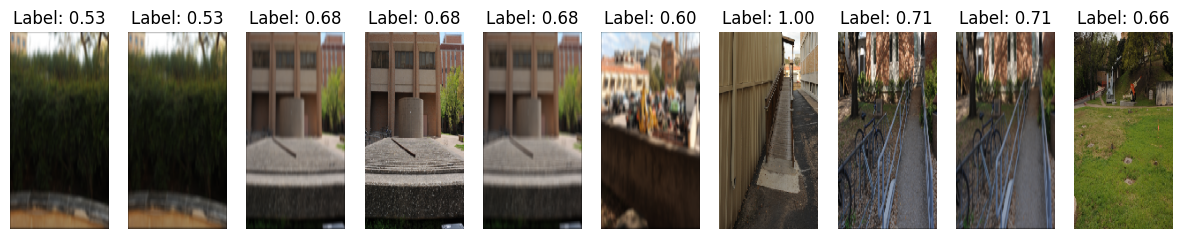

In [ ]:
display_non_reference_images(left_images, labels, num_images=10)

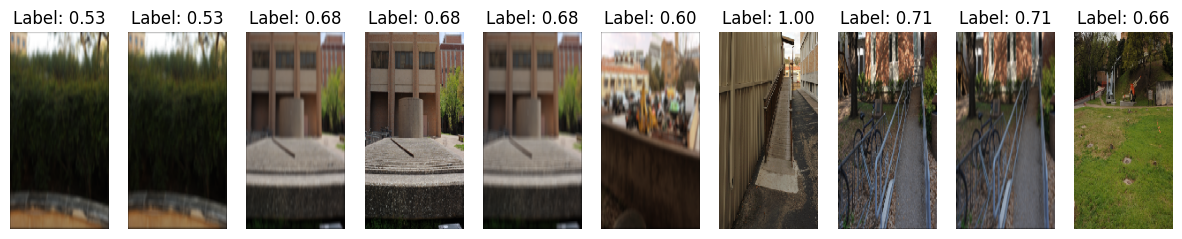

In [ ]:
display_non_reference_images(right_images, labels, num_images=10)

In [ ]:
train_left, test_left, train_right, test_right, train_labels, test_labels = train_test_split(
    left_images, right_images, labels, test_size=0.2, random_state=42
)

In [ ]:
pip install pyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.3 MB/s eta 0:00:00


In [ ]:
import pywt

In [ ]:
train_left[0].shape

(224, 112, 3)

In [ ]:
import numpy as np
import cv2
import pywt

def get_saliency_map_wavelet_rgb(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.float32)
    height, width = gray_image.shape
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    cH = cv2.resize(cH, (width, height))
    cV = cv2.resize(cV, (width, height))
    cD = cv2.resize(cD, (width, height))
    saliency_map_channel = np.sqrt(cH**2 + cV**2 + cD**2)
    saliency_map = cv2.normalize(saliency_map_channel, None, 0, 255, cv2.NORM_MINMAX)
    return saliency_map.astype(np.uint8)

In [ ]:
salience_train_left = [get_saliency_map_wavelet_rgb(image) for image in train_left]
salience_train_right = [get_saliency_map_wavelet_rgb(image) for image in train_right]

In [ ]:
salience_test_left = [get_saliency_map_wavelet_rgb(image) for image in test_left]
salience_test_right = [get_saliency_map_wavelet_rgb(image) for image in test_right]

In [ ]:
salience_train_left[0].shape

(224, 112)

In [ ]:
import tensorflow as tf
salience_train_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_left, axis=-1))
salience_train_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_right, axis=-1))

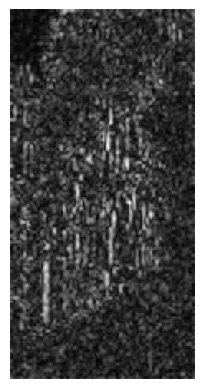

In [ ]:
image_to_display = salience_train_left_rgb[0].numpy() if isinstance(salience_train_left_rgb, tf.Tensor) else salience_train_left_rgb[0]
plt.imshow(image_to_display)
plt.axis('off')
plt.show()

In [ ]:
def display_salience_images(images,window_names=None):
    for i in range(len(images)):
        img = images[i]
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
def display_images(images, num_images=5, title="Images"):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis('off')
    plt.title(title)
    plt.show()

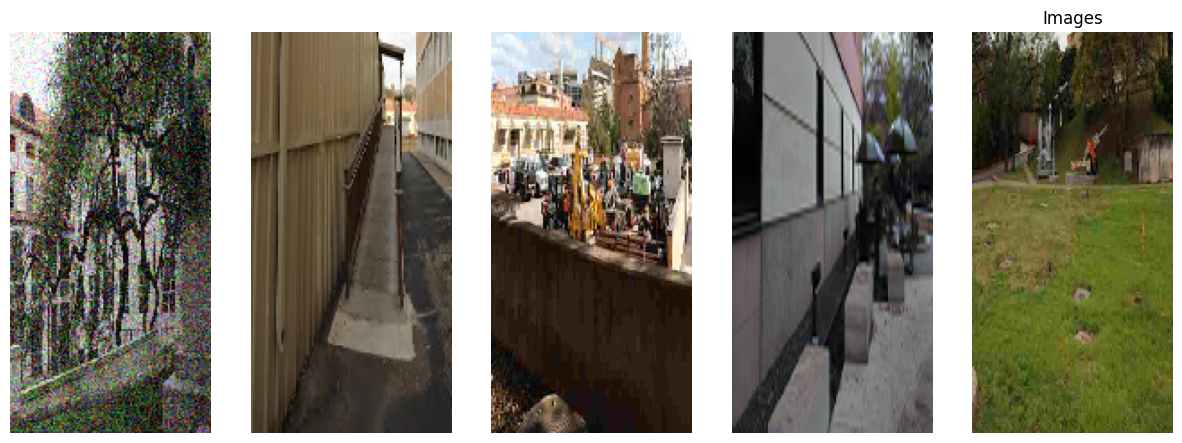

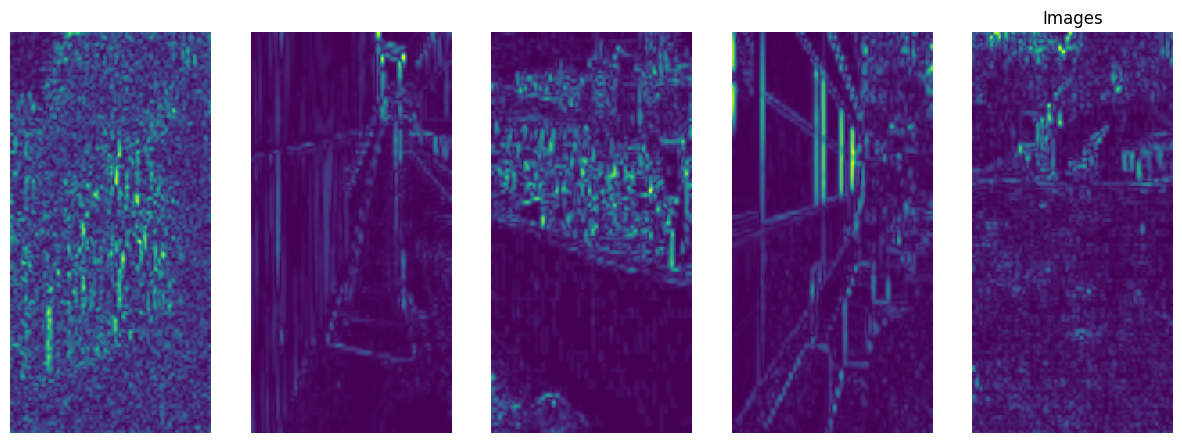

In [ ]:
display_images(train_left[:5])
display_images(salience_train_left[:5])

In [ ]:
input_shape = (224, 112, 3)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_uniform')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_feature_extractor_with_residuals(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    return tf.keras.Model(inputs=input_layer, outputs=x)

In [ ]:
def build_combined_model(left_feature_extractor, right_feature_extractor, input_shape):
    left_input = tf.keras.Input(shape=input_shape)
    right_input = tf.keras.Input(shape=input_shape)

    left_features = left_feature_extractor(left_input)
    right_features = right_feature_extractor(right_input)

    combined_features = layers.concatenate([left_features, right_features])
    combined_features = layers.Dense(1024, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.5)(combined_features)

    combined_features = layers.Dense(512, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.4)(combined_features)

    combined_features = layers.Dense(128, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.3)(combined_features)

    output = layers.Dense(1, activation='sigmoid')(combined_features)

    model = tf.keras.Model(inputs=[left_input, right_input], outputs=output)
    return model

In [ ]:
feature_extractor_left = build_feature_extractor_with_residuals(input_shape)
feature_extractor_right = build_feature_extractor_with_residuals(input_shape)

In [ ]:
combined_model = build_combined_model(feature_extractor_left, feature_extractor_right, input_shape)

In [ ]:
combined_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 112, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 112, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256)                  2840928   ['input_3[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 256)                  2840928   ['input_4[0][0]']             
                                                                                            

In [ ]:
history = combined_model.fit(
    [salience_train_left_rgb, salience_train_right_rgb],
    train_labels,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
8/8 [==============================] - 104s 13s/step - loss: 0.0245 - mae: 0.1217 - val_loss: 0.0369 - val_mae: 0.1735
Epoch 2/30
8/8 [==============================] - 102s 13s/step - loss: 0.0233 - mae: 0.1115 - val_loss: 0.0210 - val_mae: 0.1182
Epoch 3/30
8/8 [==============================] - 107s 13s/step - loss: 0.0223 - mae: 0.1159 - val_loss: 0.0243 - val_mae: 0.1373
Epoch 4/30
8/8 [==============================] - 101s 13s/step - loss: 0.0235 - mae: 0.1157 - val_loss: 0.0531 - val_mae: 0.2139
Epoch 5/30
8/8 [==============================] - 108s 14s/step - loss: 0.0215 - mae: 0.1113 - val_loss: 0.0123 - val_mae: 0.0886
Epoch 6/30
8/8 [==============================] - 106s 13s/step - loss: 0.0176 - mae: 0.1021 - val_loss: 0.0138 - val_mae: 0.0968
Epoch 7/30
8/8 [==============================] - 104s 13s/step - loss: 0.0237 - mae: 0.1185 - val_loss: 0.0516 - val_mae: 0.2043
Epoch 8/30
8/8 [==============================] - 101s 13s/step - loss: 0.0204 - mae: 0.10

In [ ]:
import tensorflow as tf
salience_test_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_left, axis=-1))
salience_test_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_right, axis=-1))

In [ ]:
test_loss, test_mae = combined_model.evaluate([salience_test_left_rgb, salience_test_right_rgb], test_labels, verbose=1)

3/3 [==============================] - 7s 2s/step - loss: 0.0212 - mae: 0.1297


In [ ]:
test_predictions = combined_model.predict([salience_test_left_rgb, salience_test_right_rgb])

3/3 [==============================] - 6s 2s/step


In [ ]:
y_true = test_labels.flatten()
y_pred = test_predictions.flatten()

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_plcc(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

def calculate_srocc(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_krocc(y_true, y_pred):
    return kendalltau(y_true, y_pred)[0]

In [ ]:
plcc_score = calculate_plcc(y_true, y_pred)
srocc_score = calculate_srocc(y_true, y_pred)
rmse_score = calculate_rmse(y_true, y_pred)
krocc_score = calculate_krocc(y_true, y_pred)

In [ ]:
print(f'PLCC: {plcc_score}')
print(f'SROCC: {srocc_score}')
print(f'RMSE: {rmse_score}')
print(f'KROCC: {krocc_score}')

PLCC: 0.8012463258769803
SROCC: 0.7861956643680813
RMSE: 0.1457009284329349
KROCC: 0.615952318626234


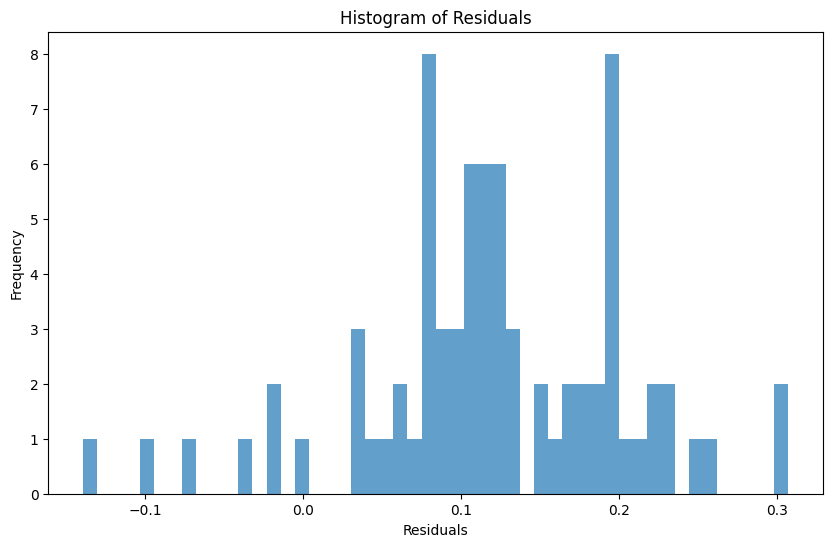

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


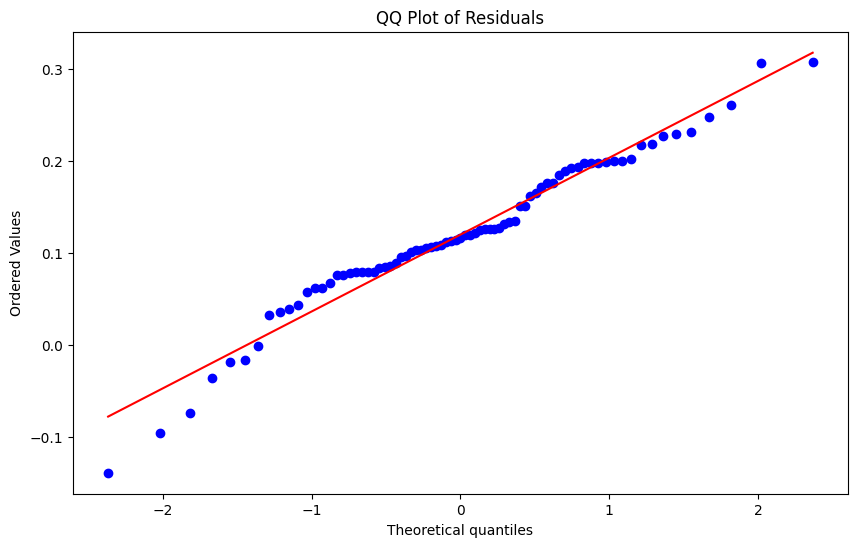

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

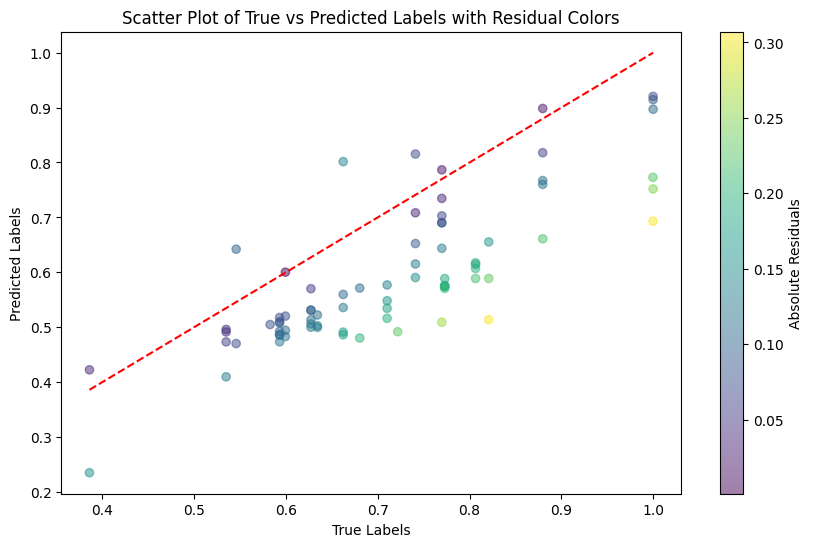

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_true - y_pred

# Create a colormap based on residuals
colors = np.abs(residuals)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_true, y_pred, c=colors, cmap='viridis', alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.colorbar(scatter, label='Absolute Residuals')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels with Residual Colors')
plt.show()

#INDIVIDUAL METRICS

In [ ]:
distortion_types = ['blur', 'ff', 'jpeg', 'jp2k', 'wn']

In [ ]:
len(salience_test_left)

77

In [ ]:
def load_dataset(base_path, ssim_scores):
    left_images = []
    right_images = []
    labels = []
    distortions = []

    # Iterate over each distortion type directory in the base path
    for distortion_type in os.listdir(base_path):
        distortion_path = os.path.join(base_path, distortion_type)

        if os.path.isdir(distortion_path):
            # Iterate over each file in the distortion directory
            for file in os.listdir(distortion_path):
                if file.endswith('_l.bmp'):
                    left_file_path = os.path.join(distortion_path, file)
                    right_file_path = left_file_path.replace('_l.bmp', '_r.bmp')

                    img_base_name = file.split('_')[0]

                    if os.path.exists(right_file_path):
                        if img_base_name in ssim_scores['Image'].values:
                            left_img = load_img(left_file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
                            right_img = load_img(right_file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

                            left_img_array = img_to_array(left_img)
                            right_img_array = img_to_array(right_img)

                            left_images.append(left_img_array)
                            right_images.append(right_img_array)
                            distortions.append(distortion_type)

                            label = ssim_scores[ssim_scores['Image'] == img_base_name]['SSIM_Score'].values[0]
                            labels.append(label)
                        else:
                            print(f"Warning: {img_base_name} not found in SSIM scores.")
                    else:
                        print(f"Warning: Right image for {file} does not exist.")

    return np.array(left_images), np.array(right_images), np.array(labels), np.array(distortions)


In [ ]:
left_images, right_images, labels, distortions = load_dataset(base_path, ssim_scores)

# Split into training and testing sets
train_left, test_left, train_right, test_right, train_labels, test_labels, train_distortions, test_distortions = train_test_split(
    left_images, right_images, labels, distortions, test_size=0.2, random_state=42
)

# Generate saliency maps for the test dataset
salience_test_left = [get_saliency_map_wavelet_rgb(image) for image in test_left]
salience_test_right = [get_saliency_map_wavelet_rgb(image) for image in test_right]


In [ ]:
from collections import defaultdict

# Dictionary to hold test images by distortion type
test_images_by_distortion = defaultdict(lambda: {'left': [], 'right': [], 'labels': [], 'salience_left': [], 'salience_right': []})

# Populate the dictionary with test images
for i, distortion_type in enumerate(test_distortions):
    test_images_by_distortion[distortion_type]['left'].append(test_left[i])
    test_images_by_distortion[distortion_type]['right'].append(test_right[i])
    test_images_by_distortion[distortion_type]['labels'].append(test_labels[i])
    test_images_by_distortion[distortion_type]['salience_left'].append(salience_test_left[i])
    test_images_by_distortion[distortion_type]['salience_right'].append(salience_test_right[i])

# Example access:
for distortion_type, data in test_images_by_distortion.items():
    print(f"Distortion: {distortion_type}")
    print(f"Left images: {len(data['left'])}")
    print(f"Right images: {len(data['right'])}")
    print(f"Labels: {len(data['labels'])}")
    print(f"Salience Left: {len(data['salience_left'])}")
    print(f"Salience Right: {len(data['salience_right'])}")


Distortion: jpeg
Left images: 13
Right images: 13
Labels: 13
Salience Left: 13
Salience Right: 13
Distortion: jp2k
Left images: 13
Right images: 13
Labels: 13
Salience Left: 13
Salience Right: 13
Distortion: ff
Left images: 23
Right images: 23
Labels: 23
Salience Left: 23
Salience Right: 23
Distortion: blur
Left images: 13
Right images: 13
Labels: 13
Salience Left: 13
Salience Right: 13
Distortion: wn
Left images: 13
Right images: 13
Labels: 13
Salience Left: 13
Salience Right: 13
Distortion: refimgs
Left images: 2
Right images: 2
Labels: 2
Salience Left: 2
Salience Right: 2


In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
def calculate_plcc(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]
def calculate_srocc(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
def calculate_krocc(y_true, y_pred):
    return kendalltau(y_true, y_pred)[0]
def convert_to_3_channels(salience_maps):
    return np.repeat(salience_maps[..., np.newaxis], 3, axis=-1)
metrics_by_distortion = {}
for distortion_type, data in test_images_by_distortion.items():
    salience_left = np.array(data['salience_left'])
    salience_right = np.array(data['salience_right'])
    true_labels = np.array(data['labels'])
    print(f"Distortion type: {distortion_type}")
    print(f"Salience left shape: {salience_left.shape}")
    print(f"Salience right shape: {salience_right.shape}")
    salience_left = convert_to_3_channels(salience_left)
    salience_right = convert_to_3_channels(salience_right)
    predictions = combined_model.predict([salience_left, salience_right]).flatten()
    plcc_score = calculate_plcc(true_labels, predictions)
    srocc_score = calculate_srocc(true_labels, predictions)
    rmse_score = calculate_rmse(true_labels, predictions)
    krocc_score = calculate_krocc(true_labels, predictions)
    metrics_by_distortion[distortion_type] = {
        'PLCC': plcc_score,
        'SROCC': srocc_score,
        'RMSE': rmse_score,
        'KROCC': krocc_score
    }
for distortion_type, metrics in metrics_by_distortion.items():
    print(f"Distortion: {distortion_type}")
    print(f"PLCC: {metrics['PLCC']}")
    print(f"SROCC: {metrics['SROCC']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"KROCC: {metrics['KROCC']}\n")


Distortion type: jpeg
Salience left shape: (13, 224, 112)
Salience right shape: (13, 224, 112)
1/1 [==============================] - 2s 2s/step
Distortion type: jp2k
Salience left shape: (13, 224, 112)
Salience right shape: (13, 224, 112)
1/1 [==============================] - 1s 1s/step
Distortion type: ff
Salience left shape: (23, 224, 112)
Salience right shape: (23, 224, 112)
1/1 [==============================] - 2s 2s/step
Distortion type: blur
Salience left shape: (13, 224, 112)
Salience right shape: (13, 224, 112)
1/1 [==============================] - 1s 1s/step
Distortion type: wn
Salience left shape: (13, 224, 112)
Salience right shape: (13, 224, 112)
1/1 [==============================] - 2s 2s/step
Distortion type: refimgs
Salience left shape: (2, 224, 112)
Salience right shape: (2, 224, 112)
1/1 [==============================] - 0s 333ms/step
Distortion: jpeg
PLCC: 0.8953000077975677
SROCC: 0.8303519364560459
RMSE: 0.15245831832717555
KROCC: 0.6667948594698255

Distortio

In [ ]:
combined_model.save('combined_model_phase1.h5')

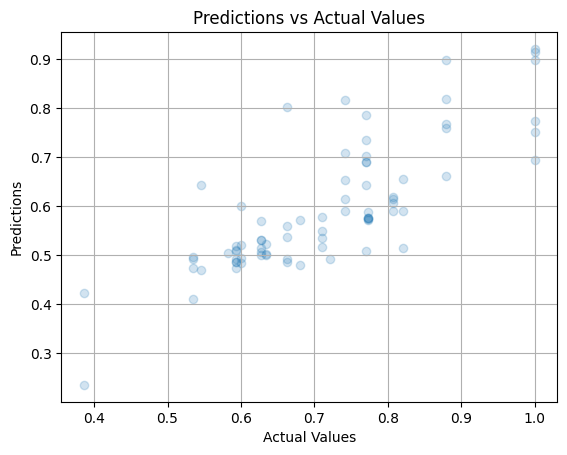

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()
